In [16]:
import ushertools
import gzip

In [24]:
mat = ushertools.UsherMutationAnnotatedTree(gzip.open("/mnt/d/public-2022-10-18.all.masked.pb.gz"))

Reading condensed nodes dict |████████████████████████████████████████| 757533/757533 [100%] in 1.4s (532595.27/s) 
Loading tree, this may take a while...
Annotating nuc muts |████████████████████████████████████████| 4252050/4252050 [100%] in 28.0s (151772.37/s) 
Expanding condensed nodes |████████████████████████████████████████| 2972450/2972450 [100%] in 52.4s (56755.99/s) 
Loaded initial tree with 6370034 tips
Tree to use now has 6370034 tips
Setting branch length |████████████████████████████████████████| 7649634/7649634 [100%] in 6.2s (1230072.32/s) 


In [25]:
import tqdm, datetime
def assign_final_genotypes(tree):
    for node in tqdm.tqdm(tree.traverse_preorder()):
        if node.parent:
            positions = {x.one_indexed_position for x in node.nuc_mutations}
            filtered_muts = [x for x in node.parent.nuc_mutations if x.one_indexed_position not in positions]
            node.nuc_mutations = filtered_muts + node.nuc_mutations
assign_final_genotypes(mat.tree)

7649634it [00:37, 204560.09it/s]


In [26]:
import tqdm, datetime
from collections import defaultdict
by_week = defaultdict(list)
for node in tqdm.tqdm(mat.tree.traverse_leaves()):
    components = node.label.split("|")
    if len(components) ==2:
        name, date = components
    elif len(components) == 3:
        name, genbank, date = components
    else:
        raise ValueError("Unexpected label format: %s" % node.label)
    
    # if date is not like yyyy-mm-dd, then skip
    if len(date) != 10:
        continue
    
    # check name starts with Eng, Wal, Scot
    if not name.startswith("Eng") and not name.startswith("Wal") and not name.startswith("Scot"):
        continue

    parsed_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    rounded_to_week = parsed_date - datetime.timedelta(days=parsed_date.weekday())
    rounded_string = rounded_to_week.strftime("%Y-%m-%d")
    by_week[rounded_string].append(node)


6370034it [00:32, 198379.20it/s]


In [27]:
from collections import Counter
import math
def calc_entropy(single_position, total):

    ref = single_position[0].ref_nuc
    filtered = [x for x in single_position if x.mut_nuc != ref]
    counter = Counter([x.mut_nuc for x in filtered])
    # add in the reference, which has value total - sum(counter.values())
    ref_number= total - sum(counter.values())
    if ref_number > 0:
        counter[ref] = ref_number
    # calculate entropy
    entropy = 0
    for nuc, count in counter.items():
        p = count / total
        entropy -= p * math.log(p)
    return entropy


def mean_entropy_for_week(single_week):
    by_position = defaultdict(list)
    total = len(single_week)
    for node in single_week:
        for mut in node.nuc_mutations:
            by_position[mut.one_indexed_position].append(mut)
    entropy_by_position = {p: calc_entropy(by_position[p], total= total) for p in by_position}
    if len(entropy_by_position) == 0:
        return 0
    current_mean = sum(entropy_by_position.values()) / len(entropy_by_position)
    number_of_constant_sites  = 30e3 - len(entropy_by_position)
    entropy_for_constant_sites = 0
    weighted_average = (current_mean * len(entropy_by_position) + entropy_for_constant_sites * number_of_constant_sites) / (len(entropy_by_position) + number_of_constant_sites)
    return weighted_average

week_to_entropy = {w: mean_entropy_for_week(single_week) for w, single_week in tqdm.tqdm(by_week.items())}


100%|██████████| 142/142 [00:28<00:00,  4.93it/s]


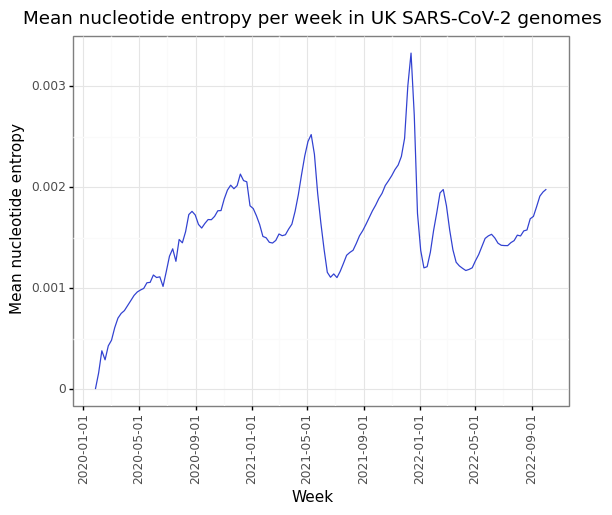

<ggplot: (8785315074949)>

In [28]:

sorted_weeks = sorted(week_to_entropy.keys())
sorted_entropies = [week_to_entropy[w] for w in sorted_weeks]
from plotnine import *
import pandas as pd
df = pd.DataFrame({"week": sorted_weeks, "entropy": sorted_entropies})
# remove final week
df = df[df.week != df.week.max()]
# convert week to datetime
df["week"] = pd.to_datetime(df["week"])

(ggplot(df, aes(x="week", y="entropy")) + geom_line(color="#3242d1") + theme_bw() + theme(axis_text_x=element_text(angle=90, hjust=0.5)) + labs(x="Week", y="Mean nucleotide entropy",title="Mean nucleotide entropy per week in UK SARS-CoV-2 genomes"))


In [29]:
# calculate the entropy of a biased coin
import math
def entropy(p):
    return -p * math.log(p) - (1-p) * math.log(1-p)

entropy(0.5)

0.6931471805599453

In [38]:
# calculate the entropy of a fair 4-sided die
def entropy(list_of_probs):
    return sum(-p * math.log(p) for p in list_of_probs)
30e3*0.0015


45.0